In [1]:
import numpy as np 
import pandas as pd 
import os
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=7697f1bac930b7cfe8b13c138a69fab980434304098941d4a6300dc2071062b2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=09043d1a6bd37a613882c38a7f580c743055629d25e047d8f23207cbc8ebe420
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random

dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
augmented_dataset_path = "/kaggle/working/augmented_dataset"  
possible_augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),  
    transforms.RandomRotation(degrees=30),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  
    transforms.RandomPerspective(distortion_scale=0.4, p=1.0),  
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0)),  
]

original_dataset = ImageFolder(root=dataset_path)
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

for class_name in original_dataset.classes:
    os.makedirs(os.path.join(augmented_dataset_path, class_name), exist_ok=True)

num_augmentations = 8  
for img_path, label in original_dataset.samples:
    img = Image.open(img_path).convert("RGB")
    class_name = original_dataset.classes[label]
    save_dir = os.path.join(augmented_dataset_path, class_name)

    img.save(os.path.join(save_dir, os.path.basename(img_path)))
    for i in range(num_augmentations):
        selected_augmentations = random.sample(possible_augmentations, k=random.randint(1, 3)) 
        transform_pipeline = transforms.Compose([transforms.Resize((227, 227))] + selected_augmentations)  
        
        augmented_img = transform_pipeline(img)
        save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(img_path)}")
        augmented_img.save(save_path)

print(f"Dataset is completely augmented ")

In [4]:
import shutil
import os

def zip_folder(folder_path, output_zip_path):
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return
    shutil.make_archive(output_zip_path, 'zip', folder_path)
    print(f"Folder '{folder_path}' has been zipped to '{output_zip_path}.zip'")

zip_folder("/kaggle/working/augmented_dataset", "/kaggle/working/augmented_dataset_zip_file")
print(f"successfully zipped")

In [5]:
augmented_dataset_path = "/kaggle/input/thermal-dataset"

In [6]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_dataset = ImageFolder(root=augmented_dataset_path, transform=transform)
train_size = int(0.6 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

num_epochs = 70
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "googlenet_trained.pth")
print("\nModel saved as googlenet_trained.pth")


Using device: cuda


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 186MB/s]
<ipython-input-7-e30acfe662f6>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/70:   0%|          | 0/108 [00:00<?, ?it/s]<ipython-input-7-e30acfe662f6>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/70, Loss: 1.6669, Accuracy: 30.69%


Epoch 2/70, Loss: 1.5867, Accuracy: 35.70%


Epoch 3/70, Loss: 1.5273, Accuracy: 38.09%


Epoch 4/70, Loss: 1.4718, Accuracy: 40.62%


Epoch 5/70, Loss: 1.4321, Accuracy: 42.84%


Epoch 6/70, Loss: 1.3854, Accuracy: 44.85%


Epoch 7/70, Loss: 1.3422, Accuracy: 48.75%


Epoch 8/70, Loss: 1.3091, Accuracy: 49.71%


Epoch 9/70, Loss: 1.2838, Accuracy: 51.19%


Epoch 10/70, Loss: 1.2542, Accuracy: 53.15%


Epoch 11/70, Loss: 1.2322, Accuracy: 54.75%


Epoch 12/70, Loss: 1.2015, Accuracy: 56.79%


Epoch 13/70, Loss: 1.1740, Accuracy: 57.40%


Epoch 14/70, Loss: 1.1637, Accuracy: 59.00%


Epoch 15/70, Loss: 1.1413, Accuracy: 58.85%


Epoch 16/70, Loss: 1.1231, Accuracy: 60.25%


Epoch 17/70, Loss: 1.1071, Accuracy: 61.09%


Epoch 18/70, Loss: 1.0999, Accuracy: 60.98%


Epoch 19/70, Loss: 1.0700, Accuracy: 63.54%


Epoch 20/70, Loss: 1.0696, Accuracy: 62.99%


Epoch 21/70, Loss: 1.0515, Accuracy: 63.08%


Epoch 22/70, Loss: 1.0388, Accuracy: 64.41%


Epoch 23/70, Loss: 1.0250, Accuracy: 64.68%


Epoch 24/70, Loss: 1.0212, Accuracy: 64.09%


Epoch 25/70, Loss: 1.0046, Accuracy: 65.52%


Epoch 26/70, Loss: 1.0073, Accuracy: 65.00%


Epoch 27/70, Loss: 0.9904, Accuracy: 65.84%


Epoch 28/70, Loss: 0.9771, Accuracy: 66.45%


Epoch 29/70, Loss: 0.9816, Accuracy: 64.94%


Epoch 30/70, Loss: 0.9672, Accuracy: 66.05%


Epoch 31/70, Loss: 0.9613, Accuracy: 65.99%


Epoch 32/70, Loss: 0.9574, Accuracy: 66.69%


Epoch 33/70, Loss: 0.9422, Accuracy: 67.21%


Epoch 34/70, Loss: 0.9347, Accuracy: 67.91%


Epoch 35/70, Loss: 0.9370, Accuracy: 66.89%


Epoch 36/70, Loss: 0.9116, Accuracy: 69.10%


Epoch 37/70, Loss: 0.9252, Accuracy: 67.59%


Epoch 38/70, Loss: 0.9088, Accuracy: 69.48%


Epoch 39/70, Loss: 0.9078, Accuracy: 68.38%


Epoch 40/70, Loss: 0.9154, Accuracy: 67.91%


Epoch 41/70, Loss: 0.9016, Accuracy: 68.75%


Epoch 42/70, Loss: 0.8979, Accuracy: 68.67%


Epoch 43/70, Loss: 0.8865, Accuracy: 70.15%


Epoch 44/70, Loss: 0.8888, Accuracy: 69.19%


Epoch 45/70, Loss: 0.8889, Accuracy: 69.04%


Epoch 46/70, Loss: 0.8746, Accuracy: 69.66%


Epoch 47/70, Loss: 0.8679, Accuracy: 69.57%


Epoch 48/70, Loss: 0.8625, Accuracy: 69.16%


Epoch 49/70, Loss: 0.8595, Accuracy: 69.71%


Epoch 50/70, Loss: 0.8621, Accuracy: 69.80%


Epoch 51/70, Loss: 0.8544, Accuracy: 70.97%


Epoch 52/70, Loss: 0.8429, Accuracy: 70.82%


Epoch 53/70, Loss: 0.8493, Accuracy: 70.70%


Epoch 54/70, Loss: 0.8573, Accuracy: 69.98%


Epoch 55/70, Loss: 0.8443, Accuracy: 70.82%


Epoch 56/70, Loss: 0.8412, Accuracy: 70.82%


Epoch 57/70, Loss: 0.8428, Accuracy: 70.30%


Epoch 58/70, Loss: 0.8352, Accuracy: 71.03%


Epoch 59/70, Loss: 0.8242, Accuracy: 71.08%


Epoch 60/70, Loss: 0.8300, Accuracy: 70.21%


Epoch 61/70, Loss: 0.8339, Accuracy: 70.38%


Epoch 62/70, Loss: 0.8225, Accuracy: 70.68%


Epoch 63/70, Loss: 0.8218, Accuracy: 70.94%


Epoch 64/70, Loss: 0.8198, Accuracy: 71.52%


Epoch 65/70, Loss: 0.8128, Accuracy: 71.20%


Epoch 66/70, Loss: 0.8139, Accuracy: 71.35%


Epoch 67/70, Loss: 0.8066, Accuracy: 71.49%


Epoch 68/70, Loss: 0.8106, Accuracy: 71.20%


Epoch 69/70, Loss: 0.8018, Accuracy: 71.23%


Epoch 70/70, Loss: 0.8065, Accuracy: 71.55%

Model saved as googlenet_trained.pth


In [8]:
import numpy as np
import torch

class_names = augmented_dataset.classes  
num_classes = len(class_names)  

def calculate_per_class_accuracy(model, data_loaders, device, datasets=["Training", "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes) 
        class_total = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        print(f"\n Final Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):  
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"{class_names[i]}: {dataset_type} = {accuracy:.2f}%")
            else:
                print(f"{class_names[i]}: {dataset_type} = No samples available ")

data_loaders = [train_loader, val_loader, test_loader]
datasets = ["Training", "Validation", "Test"]
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)


 Final Per-Class Training Accuracy:

BLB: Training = 85.54%
Blast: Training = 44.57%
healthy: Training = 77.19%
hispa: Training = 79.67%
leaf folder: Training = 88.83%
leaf spot: Training = 68.91%

 Final Per-Class Validation Accuracy:

BLB: Validation = 79.26%
Blast: Validation = 30.08%
healthy: Validation = 77.97%
hispa: Validation = 78.48%
leaf folder: Validation = 82.26%
leaf spot: Validation = 54.29%

 Final Per-Class Test Accuracy:

BLB: Test = 80.54%
Blast: Test = 27.68%
healthy: Test = 74.56%
hispa: Test = 81.50%
leaf folder: Test = 89.29%
leaf spot: Test = 58.39%


Test Accuracy: 72.25%


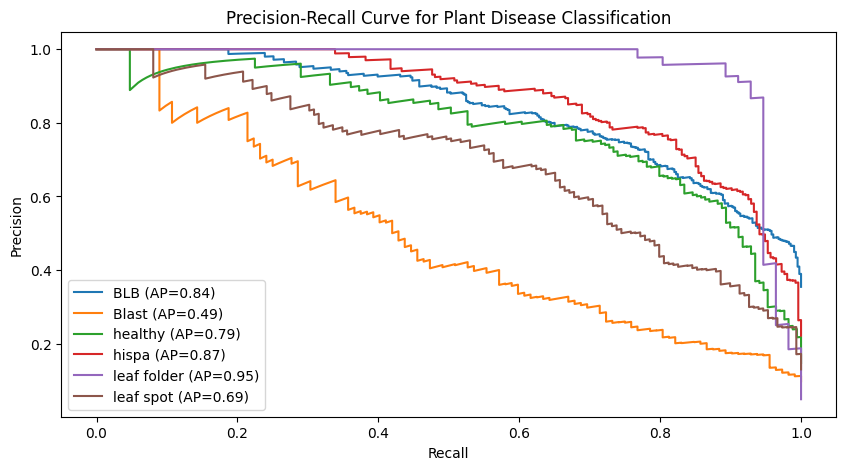

In [9]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
y_true = []
y_scores = []
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

plt.figure(figsize=(10, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Plant Disease Classification")
plt.legend()
plt.show()

In [10]:
""" 

UNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,
ViT, EfficientNetv2
"""

' \n\nUNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,\nViT, EfficientNetv2\n'

In [11]:
# alexnet , resnet , googlenet , unet , vgg
# segnet , inception , rcnn , vit  , efficient net